# Forecasting NYC Traffic Accidents

## Using Autoregressive Integrated Moving Average

### Summary
The data used for this project was retrieved from:
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

In summary, I wanted to visualize the impact COVID-19 had on the total number of NYC traffic accidents. This involved forecasting future months based off previous data not influenced by the pandemic.

### ARIMA models

To do the forecasting I created a Autoregressive Integrated Moving Average model. This model can be broken into three parts. 

First Autoregression (AR) refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.

Next Integrated (I) represents the differencing of raw observations to allow for the time series to become stationary. 

Lastly the Moving Average (MA) incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

### Raw Data

To begin we start by visualizing the data from 2013 to 2020. Notice the seasonal change and general increase in total accidents over time with the exception of 2019.

In [8]:
import dash
import dash_core_components as dcc
import dash_html_components as html

In [9]:
import pandas as pd
import numpy as np
import pmdarima as pm
from IPython.display import display, HTML

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
rcParams['figure.figsize'] = 16, 10
%matplotlib inline
import matplotlib as mpl

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime as dt

import warnings

In [10]:
#Acquired data from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

#df = pd.read_json('https://data.cityofnewyork.us/resource/h9gi-nx95.json?' +\
#             '$where=crash_date>"2019-12-31T00:00:00.000"' +\
#             '&$limit=2000000').replace(' ', '%20')

#df.crash_date = pd.to_datetime(df.crash_date)
#df = df['crash_date'].groupby(df.crash_date.dt.to_period("M")).agg('count')
#print(df)

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/willoutcault/NYC_Accidents_ARIMA_Forcast/master/Accidents.csv")
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])

warnings.filterwarnings('ignore')
indexedDataset = df[0:91]

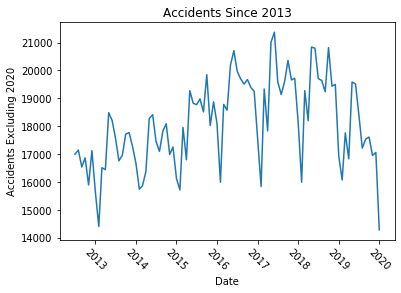

In [12]:
plt.xlabel("Date")
plt.ylabel("Accidents Excluding 2020")
plt.title("Accidents Since 2013")
plt.xticks(rotation=-45)
plt.plot(indexedDataset)

### Stationarity

We want to begin by making the data stationary, specifically we want to show the data is consitence over time. To measure these we find the rolling mean and rolling standard deviation, and then run a Dickey-Fullter Test to calculate our test statistic. In general if our test statistic is larger than our critical values we can conclude that our data is stationary.

Before finding these values we take the log value of the differenced data points. Then we plot these trends and view our test statistic.

In our case our test statistic is larger than the critical values. In addition we notice the moving average remains around 0 which further shows stationary data.

In [13]:
def test_stationarity(timeseries):
    movingAverage = timeseries.rolling(window=12).mean()
    movingStd = timeseries.rolling(window=12).std()
    
    orig = plt.plot(timeseries, color='darkgreen', label='Original')
    mean = plt.plot(movingAverage, color='blue', label='Rolling Mean')
    std = plt.plot(movingStd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Accidents'], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

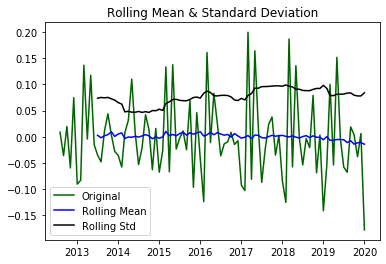

Results of Dickey-Fuller Test:
Test Statistic                 -1.086181
p-value                         0.720551
#Lags Used                     12.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


In [20]:
# Getting Log Value
indexedDataset_logScale = np.log(indexedDataset)
# Subtracting Rolling Average And STD
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingStd = indexedDataset_logScale.rolling(window=12).std()
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
# Time-Shift The Data (1 Degree)
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift(1)
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [32]:
%%capture
# Optimizing Parameters (p,q,m)
smodel = pm.auto_arima(indexedDataset_logScale['Accidents'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True);


### Optimizing Parameters

The next step will be to optimize our three parameters p, d and q.

p: the number of lag observations in the model; also known as the lag order.

d: the number of times that the raw observations are differenced; also known as the degree of differencing.

q: the size of the moving average window; also known as the order of the moving average.

###  Visualizing Our Predictions

After optimization we can predict the future number of accidents that will occur in NYC.

Our raw data is shown in blue and predicted data shown in green which includes a 95% confidence Interval. Our raw data shown ranges from 2013 through January 2020. Our model then predicts each month's total number of accidents for the remainder of 2020.

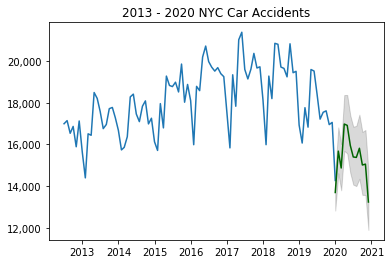

In [51]:
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexedDataset_logScale.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig, ax = plt.subplots()
plt.plot(np.exp(indexedDataset_logScale))
plt.plot(np.exp(fitted_series), color='darkgreen')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.fill_between(lower_series.index, 
                 np.exp(lower_series), 
                 np.exp(upper_series), 
                 color='k', alpha=.15)

plt.title("2013 - 2020 NYC Car Accidents")
plt.show()

### Analyzing the Effects from COVID-19 

The purpose of this project was to determine how COVID-19 affected the total number of monthly NYC traffic accidents. We begin by taking a closer look at the months of interest. 

We see in the graph below our projected values follow a similar trend from 2019. January's total number of accidents were actually more than projected, however we see a major dropoff see the effects take place starting in February.

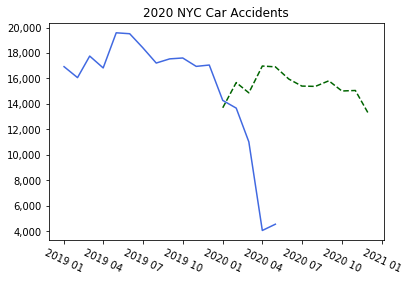

In [52]:
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexedDataset_logScale.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig, ax = plt.subplots()
plt.plot(df[78:], color='royalblue', label = 'Actual')
plt.plot(np.exp(fitted_series[:]), color='darkgreen', linestyle='dashed', label = 'Projected')
monthyearFmt = mdates.DateFormatter('%Y %m')
ax.xaxis.set_major_formatter(monthyearFmt)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=-25)

plt.title("2020 NYC Car Accidents")
plt.show()

### Results

Lastly we want to quantify our results. Specifically I wanted to calculate the percent change in total number of accidents during 2020. 

The total number of accidents were up in January and then dropped 13% in February. The number of accidents continued to drop in March by 26% and in April accidents were down by 76%. In May accidents begin to level off, by the end of the month we were down a total of 73%. We can expect a gradual increase in the number of accidents in NYC and a sudden resurgence once quarantine is lifted. 

In [64]:
fitted_series_exp = round(np.exp(fitted_series), 0)

percent_change = (100*(df.values[90:95,0]/fitted_series_exp.values[0:5])-100)

dt = pd.DataFrame({"Month":df.index[90:95], "Projections":fitted_series_exp.values[0:5],
                   "Actual":df.values[90:95,0], "Percent Change":percent_change})
dt

,Month,Projections,Actual,Percent Change
0,2020-01-01,13699.0,14276,4.211986
1,2020-02-01,15680.0,13671,-12.812500
2,2020-03-01,14871.0,11021,-25.889315
3,2020-04-01,16977.0,4059,-76.091182
4,2020-05-01,16913.0,4551,-73.091705


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')